<a href="https://colab.research.google.com/github/t-chapman/telco_churn/blob/main/Telco_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>Overview and Information about the Data </u>  

One of the biggest challenges that telecommunication companies are facing, is the retention
of customers. It’s very usual for customers to be choosing to switch providers in search for a
better deal.  
  

You are provided with a dataset containing anonymised data from a telecommunications
provider. Each row represents one customer and provides different kind of information
about them.
The dataset includes a column which specifies whether or not the customer was retained or
whether they churned.  
  

# <u>Objective</u>  
  

The ultimate goal would be to build a model, which can predict which customers the
company is less likely to retain.
Through this process, it would also be important to identify which are the primary factors
which predict churn.







Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.model_selection import (GridSearchCV, train_test_split)
from sklearn.tree import (DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Import data

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/t-chapman/telco_churn/main/demo_telco_churn.csv")

# 1) Inspect and Clean Data

In [3]:
df.shape

(7043, 22)

In [4]:
df.head()

,custID,Gender,IsRetired,IsMarried,HasChildren,TotalMonthsInContract,HasPhone,ConnectionType,HasAntivirusSubscription,HasCloudBackUp,HasInsurance,HasHelpdeskPrivileges,HasTVPackage,HasMoviePackage,PayTerm,OnlineStatements,PreferredPaymentType,MonthlyBill,TotalFees,MonthlySpend,RetentionCheck,Retention
0,7590-VHVEG,Female,0,Yes,No,1,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,22.40,Yes,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,56.82,Yes,Yes
2,3668-QPYBK,Male,0,No,No,2,Yes,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,54.93,No,No
3,7795-CFOCW,Male,0,No,No,45,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,35.24,Yes,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,70.16,Yes,No


'custID' can be dropped as is no use for modelling

In [5]:
df.drop('custID', axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    7043 non-null   object 
 1   IsRetired                 7043 non-null   int64  
 2   IsMarried                 7043 non-null   object 
 3   HasChildren               7043 non-null   object 
 4   TotalMonthsInContract     7043 non-null   int64  
 5   HasPhone                  7043 non-null   object 
 6   ConnectionType            7043 non-null   object 
 7   HasAntivirusSubscription  7043 non-null   object 
 8   HasCloudBackUp            7043 non-null   object 
 9   HasInsurance              7043 non-null   object 
 10  HasHelpdeskPrivileges     7043 non-null   object 
 11  HasTVPackage              7043 non-null   object 
 12  HasMoviePackage           7043 non-null   object 
 13  PayTerm                   7043 non-null   object 
 14  OnlineSt

The feature "TotalFees" is an object, which contains "£"\
Remove the "£" (and anything else not numeric) using regex, and convert to a float

In [7]:
df['TotalFees'] = pd.to_numeric(df['TotalFees'].replace('[^0-9.]', '', regex = True), errors = 'coerce')

In [8]:
print(df.isnull().sum())

Gender                       0
IsRetired                    0
IsMarried                    0
HasChildren                  0
TotalMonthsInContract        0
HasPhone                     0
ConnectionType               0
HasAntivirusSubscription     0
HasCloudBackUp               0
HasInsurance                 0
HasHelpdeskPrivileges        0
HasTVPackage                 0
HasMoviePackage              0
PayTerm                      0
OnlineStatements             0
PreferredPaymentType         0
MonthlyBill                  0
TotalFees                   11
MonthlySpend                 0
RetentionCheck               0
Retention                    0
dtype: int64


'TotalFees' has 11 instances of null values. One way to deal with these would be to impute using mean or median. However, reading the data dictionary suggests an alternative approach.  


> 'TotalFees' = The total amount billed to the customer  
> 'MonthlyBill' = The amount billed to the customer monthly  
> 'TotalMonthsInContract' = Number of months that the customer has been with the company.  

Hypothesis is that 'MonthlyBill' x 'TotalMonthsInContract' = 'TotalFees'  
This can be verified by plotting 'MonthlyBill' x 'TotalMonthsInContract' against 'TotalFees'









<function matplotlib.pyplot.show>

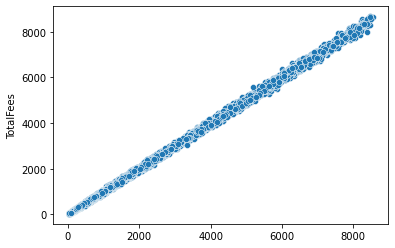

In [9]:
TotalFees_proxy=df['MonthlyBill']*df['TotalMonthsInContract']
sns.scatterplot(x=TotalFees_proxy,y=df['TotalFees'])
plt.show

Given this outcome, using 'TotalFees_proxy' is likely to be more reliable than using mean or median 

In [10]:
missing_col = ['TotalFees']

for i in missing_col:
 df.loc[df.loc[:,i].isnull(),i]=df['TotalMonthsInContract']*df['MonthlyBill']

In [11]:
df.describe()

,IsRetired,TotalMonthsInContract,MonthlyBill,TotalFees,MonthlySpend
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,64.813767
std,0.368612,24.559481,30.090047,2266.794470,30.261963
min,0.000000,0.000000,18.250000,0.000000,6.780000
25%,0.000000,9.000000,35.500000,398.550000,36.020000
50%,0.000000,29.000000,70.350000,1394.550000,70.900000
75%,0.000000,55.000000,89.850000,3786.600000,89.925000
max,1.000000,72.000000,118.750000,8684.800000,124.930000


Observation : values for 'MonthlyBill' and 'MonthlySpend' are very similar.  Requires further investigation (likely highly correlated, and therefore potentially exclude one of them)

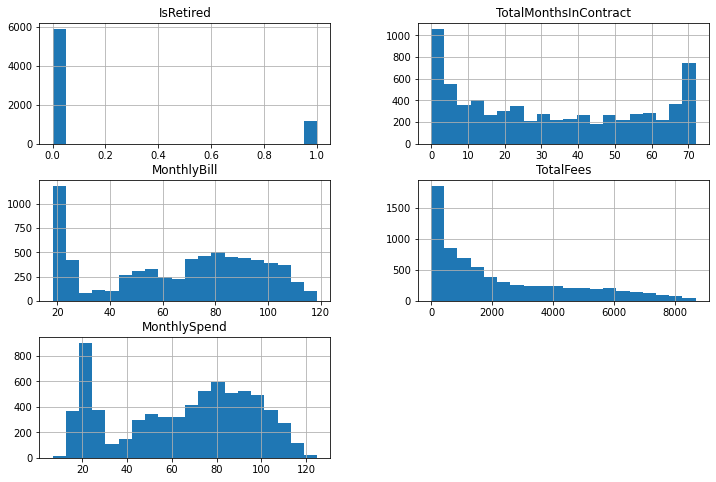

In [12]:
df.hist(figsize=(12,8),bins=20)
plt.show()

Observation : 'TotalFees' looks potentially skewed, and could be addressed through transformation

**Identify Target**

Data Dictionary defines column that indicates if a customer has churned or not  


> '**Retention**' : Has the customer stayed with the company or left.



In [13]:
df["Retention"].value_counts()

Yes    5174
No     1869
Name: Retention, dtype: int64

However, there is another column that appears to have very similar (but not identical) values :


> '**RetentionCheck**' : Column filled by the customer service department.

In [14]:
pd.crosstab(df['Retention'],df["RetentionCheck"])

RetentionCheck,No,Yes
Retention,,
No,1778,91
Yes,261,4913


There are 352 instances where  'Retention' is potentially ambiguous, and may impact the quality of the model. Therefore, I will drop these instances

In [15]:
#drop rows where Retention and RetentionCheck do not agree
df.drop(df[df['Retention']!=df['RetentionCheck']].index, axis=0, inplace=True)

In [16]:
pd.crosstab(df['Retention'],df["RetentionCheck"])

RetentionCheck,No,Yes
Retention,,
No,1778,0
Yes,0,4913


As we are trying to predict ***churn*** rather than ***retention***, we need to set the positive class of the Target variable to 1 - i.e. Retention='No' should be Churn=1

In [17]:
df.loc[df[df['Retention']=='No'].index,'Churn']=1
df.loc[df[df['Retention']=='Yes'].index,'Churn']=0

Drop 'Retention' &'RetentionCheck' as they are no longer needed

In [18]:
df.drop(df[['Retention','RetentionCheck']], axis=1, inplace=True)

In [19]:
df['Churn'].value_counts()

0.0    4913
1.0    1778
Name: Churn, dtype: int64

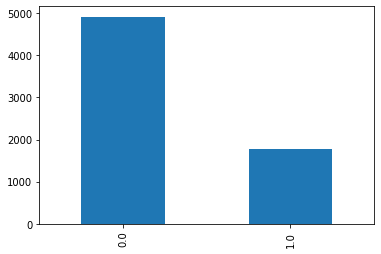

In [20]:
df['Churn'].value_counts().plot(kind='bar')

**Note: Imbalanced Class - will need to deal with this before modelling**


# 2) Exploratory Data Analysis

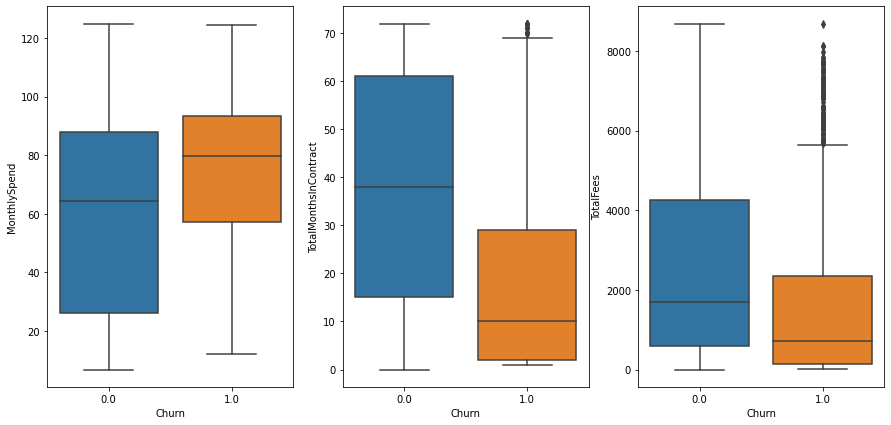

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
sns.boxplot(x=df['Churn'], y=df['MonthlySpend'], ax=ax[0])
sns.boxplot(x=df['Churn'], y=df['TotalMonthsInContract'], ax=ax[1])
sns.boxplot(x=df['Churn'], y=df['TotalFees'], ax=ax[2])

[Text(0.5, 1.0, 'OnlineStatements')]

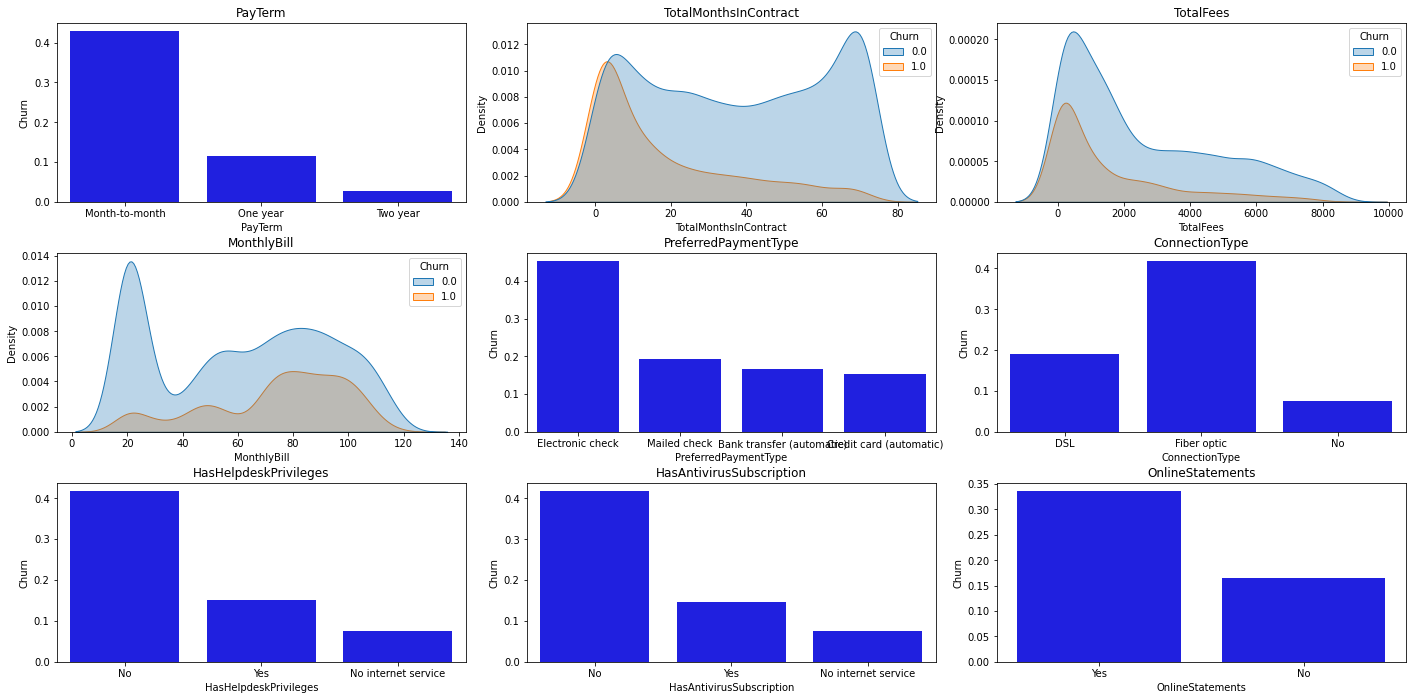

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
plt.tight_layout(pad=3.0)
#Top row
sns.barplot(x=df['PayTerm'], y=df['Churn'], color = 'blue',ci = None ,  ax=ax[0,0]).set(title='PayTerm')
sns.kdeplot(data=df, x="TotalMonthsInContract", hue="Churn", fill="true", alpha=0.3, ax=ax[0,1]).set(title='TotalMonthsInContract')
sns.kdeplot(data=df, x="TotalFees",  hue="Churn", multiple="layer", fill="true", alpha=0.3, ax=ax[0,2]).set(title='TotalFees')

#2nd Row
sns.kdeplot(data=df, x="MonthlyBill",  hue="Churn", multiple="layer", fill="true", alpha=0.3, ax=ax[1,0]).set(title='MonthlyBill')
sns.barplot(x=df['PreferredPaymentType'], y=df['Churn'], color = 'blue',ci = None ,  ax=ax[1,1]).set(title='PreferredPaymentType')
sns.barplot(x=df['ConnectionType'], y=df['Churn'], color = 'blue',ci = None ,  ax=ax[1,2]).set(title='ConnectionType')

#3nd Row
sns.barplot(x=df["HasHelpdeskPrivileges"], y=df['Churn'], color = 'blue',ci = None , ax=ax[2,0]).set(title='HasHelpdeskPrivileges')
sns.barplot(x=df['HasAntivirusSubscription'], y=df['Churn'], color = 'blue',ci = None ,  ax=ax[2,1]).set(title='HasAntivirusSubscription')
sns.barplot(x=df['OnlineStatements'], y=df['Churn'], color = 'blue',ci = None ,  ax=ax[2,2]).set(title='OnlineStatements')


# 3) Data Preprocessing

Products that are add-on packages for Internet ('HasAntivirusSubscription', 'HasCloudBackUp', 'HasInsurance', 'HasHelpdeskPrivileges', 'HasTVPackage', 'HasMoviePackage') are all set to 'No internet service' where the customer has no internet (ConnectionType='No').\
As the customer does not have these services, this can be set to 'No'.\
(n.b. if we were to OneHot Encode thes columns, they would each return an (identical) 'No internet service' colummn, which would be identical to the Onehot encoded ConnectionType='No', so we are not losing any information.


In [23]:
no_internet_columns=['HasAntivirusSubscription','HasCloudBackUp','HasInsurance','HasHelpdeskPrivileges','HasTVPackage','HasMoviePackage']

In [24]:
for col in no_internet_columns:
  df[col]=df[col].replace({'No internet service':'No'})

Encode 'Yes'/'No' binary features as 1 and 0

In [25]:
yes_no_columns=['IsMarried','HasChildren','HasPhone','HasAntivirusSubscription','HasCloudBackUp','HasInsurance','HasHelpdeskPrivileges','HasTVPackage','HasMoviePackage','OnlineStatements']

In [26]:
for col in yes_no_columns:
  df[col]=df[col].replace({'Yes':1, 'No':0})

'Gender' is also a binary feature and should be encoded 1 and 0

In [27]:
df['Gender']=df['Gender'].replace({'Female':1, 'Male':0})

Feature 'PayTerm' has relative rank, and therefore should be encoded as ordinal

In [28]:
def ordinal_encoder(data,feature,feature_rank):
    
    ordinal_dict = {}
    
    for i, feature_value in enumerate(feature_rank):
        ordinal_dict[feature_value]=i+1
    
    data[feature] = data[feature].map(lambda x: ordinal_dict[x])
    
    return data

In [29]:
df = ordinal_encoder(df,'PayTerm',['Month-to-month','One year','Two year'])

Onehot Encode Categorical Features

In [30]:
#df = df_ordinal_processed
categorical_columns = ['ConnectionType','PreferredPaymentType']
for col in categorical_columns:
    #first replace non alphanumeric with an underscore, to make encoded feature names a bit cleaner
    df[col].replace(to_replace="[^0-9a-zA-Z]+",value="_",regex=True, inplace=True)
    col_ohe = pd.get_dummies(df[col], prefix=col)
    df = pd.concat((df, col_ohe), axis=1).drop(col, axis=1)


# 4) Feature Selection and Engineering

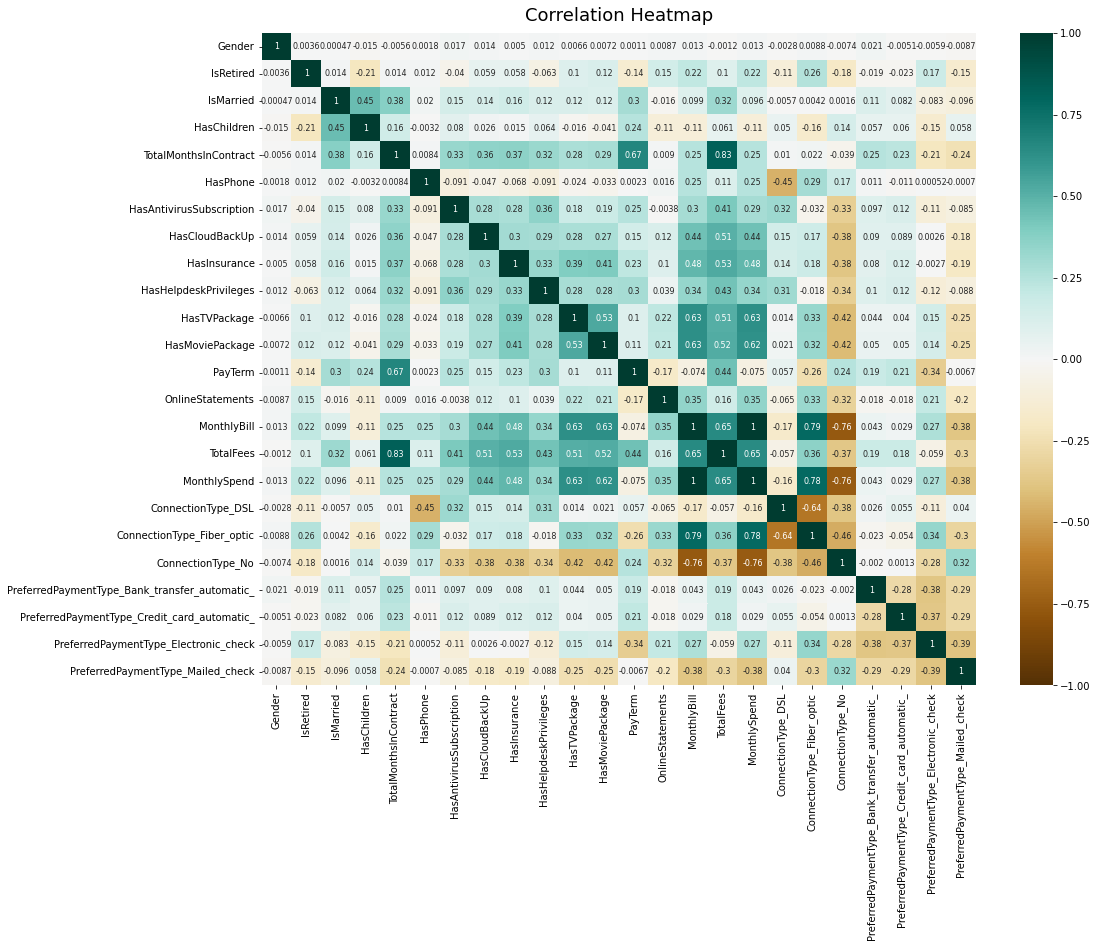

In [31]:
features = df.drop('Churn', axis=1)
corr = features.corr()

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":8}, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

'MonthlyBill' and 'MonthlySpend' have correlation of 1.    
*Note - 'MonthlySpend' does not appear in the Data Dictionary, so have no information with which to decide how to treat it, so must investigate.*

<function matplotlib.pyplot.show>

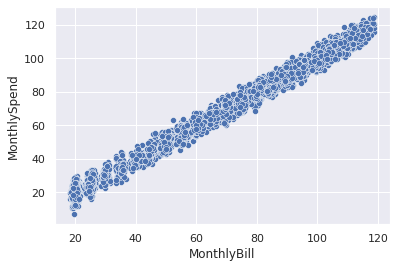

In [32]:
sns.set_theme()
sns.scatterplot(data=df,x='MonthlyBill',y='MonthlySpend')
plt.show

Hypothesis : 'MonthlyBill' is the billed amount, whereas 'MonthlySpend' is what the customer actually pays.  Any difference between the two is over/under spend??
Create a new feature, the difference between spend an billed amount

In [33]:
df['BillVsSpendDiff']=df['MonthlySpend']-df['MonthlyBill']

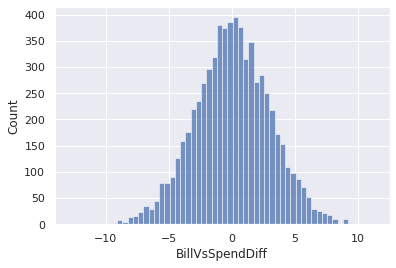

In [34]:
sns.histplot(df['BillVsSpendDiff'])

Now we only need to keep one of 'MonthlyBill' and 'MonthlySpend', so will drop 'MonthlySpend'

In [35]:
df.drop('MonthlySpend',axis=1, inplace=True)

# 5) Split the dataset into Train and Test

In [36]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

#6) Standardise and Resample to Correct Imbalance

In [37]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# 7) Build Baseline Models

Initial Models using Default Parameters

Will try:  


*   Logistic Regression
*   Random Forest
*   K Nearest Neigbor






In [38]:
logreg = LogisticRegression()
logreg.fit(X_train_resampled, y_train_resampled)
# Predict the test set labels
y_pred_logreg=logreg.predict(X_test)
# Predict the test set probabilites
y_probs_logreg=logreg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_logreg))

auc_logreg=roc_auc_score(y_test, y_probs_logreg)
accuracy_logreg=accuracy_score(y_test,y_pred_logreg)
print('\n')
print("ROC AUC Score: %f" % (auc_logreg))
print("Accuracy: %f" %  (accuracy_logreg))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_logreg)))

              precision    recall  f1-score   support

         0.0       0.92      0.72      0.80      1491
         1.0       0.50      0.81      0.62       517

    accuracy                           0.74      2008
   macro avg       0.71      0.76      0.71      2008
weighted avg       0.81      0.74      0.76      2008



ROC AUC Score: 0.844891
Accuracy: 0.741534


Confusion Matrix : 
[[1069  422]
 [  97  420]]


Random Forest on Resampled Data

In [39]:
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
# Predict the test set labels
y_pred_rf=rf.predict(X_test)
# Predict the test set probabilites
y_probs_rf=rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))

auc_rf=roc_auc_score(y_test, y_probs_rf)
accuracy_rf=accuracy_score(y_test,y_pred_rf)
print('\n')
print("ROC AUC Score: %f" % (auc_rf))
print("Accuracy: %f" %  (accuracy_rf))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_rf)))

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      1491
         1.0       0.50      0.78      0.61       517

    accuracy                           0.74      2008
   macro avg       0.70      0.75      0.71      2008
weighted avg       0.80      0.74      0.76      2008



ROC AUC Score: 0.836029
Accuracy: 0.741534


Confusion Matrix : 
[[1086  405]
 [ 114  403]]


Random Forest on Original (non-Resampled) Data, but use `class_weight="balanced" `instead

In [40]:
rf_bal = RandomForestClassifier(class_weight="balanced")
rf_bal.fit(X_train, y_train)
# Predict the test set labels
y_pred_rf_bal=rf_bal.predict(X_test)
# Predict the test set probabilites
y_probs_rf_bal=rf_bal.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf_bal))

auc_rf_bal=roc_auc_score(y_test, y_probs_rf_bal)
accuracy_rf_bal=accuracy_score(y_test,y_pred_rf_bal)
print('\n')
print("ROC AUC Score: %f" % (auc_rf_bal))
print("Accuracy: %f" %  (accuracy_rf_bal))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_rf_bal)))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1491
         1.0       0.65      0.47      0.55       517

    accuracy                           0.80      2008
   macro avg       0.74      0.69      0.71      2008
weighted avg       0.79      0.80      0.79      2008



ROC AUC Score: 0.833841
Accuracy: 0.799303


Confusion Matrix : 
[[1363  128]
 [ 275  242]]


Random Forest using all data with class_weight="balanced" results in slightly lower ROC_AUC_Score, but negatively impacts recall

In [41]:
knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)
# Predict the test set labels
y_pred_knn=knn.predict(X_test)
# Predict the test set probabilites
y_probs_knn=knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_knn))

auc_knn=roc_auc_score(y_test, y_probs_knn)
accuracy_knn=accuracy_score(y_test,y_pred_knn)
print('\n')
print("ROC AUC Score: %f" % (auc_knn))
print("Accuracy: %f" %  (accuracy_knn))
print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_knn)))

              precision    recall  f1-score   support

         0.0       0.89      0.66      0.76      1491
         1.0       0.44      0.77      0.56       517

    accuracy                           0.69      2008
   macro avg       0.67      0.72      0.66      2008
weighted avg       0.78      0.69      0.71      2008



ROC AUC Score: 0.776679
Accuracy: 0.690737


Confusion Matrix : 
[[989 502]
 [119 398]]


N.B. repeated use of same code for each model. Would be better if I wrote a function to do this (still to do...)

Generate Plot of ROC curve

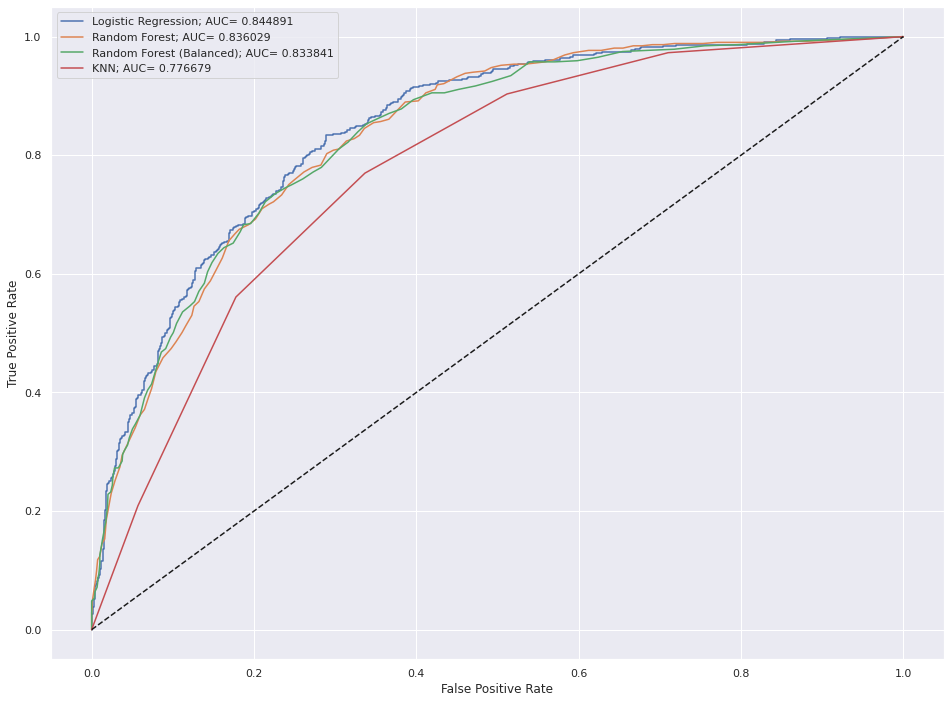

In [42]:
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, y_probs_logreg)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_probs_rf)
rf_bal_fpr, rf_bal_tpr, rf_bal_thresholds = roc_curve(y_test, y_probs_rf_bal)
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, y_probs_knn)

plt.figure(figsize=(16,12))
plt.plot(logreg_fpr, logreg_tpr, label="Logistic Regression; AUC= %f" % (auc_logreg))
plt.plot(rf_fpr, rf_tpr, label="Random Forest; AUC= %f" % (auc_rf))
plt.plot(rf_bal_fpr, rf_bal_tpr, label="Random Forest (Balanced); AUC= %f" % (auc_rf_bal))
plt.plot(knn_fpr, knn_tpr, label="KNN; AUC= %f" % (auc_knn))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.show()


# 8) Tune Hyperparameters using GridSearch and Cross Validation

Note: decided that based on information available to use `scoring='roc_auc'  `
AUC as it is a function of sensitivity and specificity, the curve is insensitive to disparities in the class proportions.  
  
  If more information was available about (a) the cost of losing a customer who churns, and (b) the cost to retain a customer at risk, then 'Recall' may be a 
more appropriate metric


In [43]:
%%time
param_grid = {'penalty': ['l1', 'l2'],
              'C':[0.001,.009,0.01,.09,1,5,10,25]}

logreg_grid = GridSearchCV(logreg, param_grid, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)
logreg_grid.fit(X_train_resampled,y_train_resampled)
# Extract best hyperparameters from 'logreg_grid'
best_hyperparams_logreg = logreg_grid.best_params_
print('Best hyerparameters:\n', best_hyperparams_logreg)
# Extract the best model from 'logreg_grid'
best_model_logreg = logreg_grid.best_estimator_
# Predict the test set labels
y_pred_logreg_grid=best_model_logreg.predict(X_test)
# Predict the test set probabilites
y_probs_logreg_grid=best_model_logreg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_logreg_grid))

auc_logreg_grid=roc_auc_score(y_test, y_probs_logreg_grid)
accuracy_logreg_grid=accuracy_score(y_test,y_pred_logreg_grid)
precision_logreg_grid=precision_score(y_test,y_pred_logreg_grid)
recall_logreg_grid=recall_score(y_test,y_pred_logreg_grid)
f1_logreg_grid=f1_score(y_test,y_pred_logreg_grid)
print('\n')
print("Accuracy: %f" %  (accuracy_logreg_grid))
print("Precision: %f" %  (precision_logreg_grid))
print("Recall: %f" %  (recall_logreg_grid))
print("F1 Score: %f" %  (f1_logreg_grid))
print("ROC AUC Score: %f" % (auc_logreg_grid))

print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_logreg_grid)))
print('\n')

Best hyerparameters:
 {'C': 5, 'penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.92      0.72      0.81      1491
         1.0       0.50      0.82      0.62       517

    accuracy                           0.74      2008
   macro avg       0.71      0.77      0.71      2008
weighted avg       0.81      0.74      0.76      2008



Accuracy: 0.742530
Precision: 0.500000
Recall: 0.816248
F1 Score: 0.620132
ROC AUC Score: 0.845038


Confusion Matrix : 
[[1069  422]
 [  95  422]]


CPU times: user 412 ms, sys: 112 ms, total: 524 ms
Wall time: 1.8 s


In [44]:
%%time
param_grid = {'max_depth': [3, 5, 6, 7, 8],
              'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

rf_grid = GridSearchCV(rf, param_grid, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train_resampled,y_train_resampled)
# Extract best hyperparameters from 'rf_grid'
best_hyperparams_rf = rf_grid.best_params_
print('Best hyerparameters:\n', best_hyperparams_rf)
# Extract the best model from 'rf_grid'
best_model_rf = rf_grid.best_estimator_
# Predict the test set labels
y_pred_rf_grid=best_model_rf.predict(X_test)
# Predict the test set probabilites
y_probs_rf_grid=best_model_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf_grid))

auc_rf_grid=roc_auc_score(y_test, y_probs_rf_grid)
accuracy_rf_grid=accuracy_score(y_test,y_pred_rf_grid)
precision_rf_grid=precision_score(y_test,y_pred_rf_grid)
recall_rf_grid=recall_score(y_test,y_pred_rf_grid)
f1_rf_grid=f1_score(y_test,y_pred_rf_grid)
print('\n')
print("Accuracy: %f" %  (accuracy_rf_grid))
print("Precision: %f" %  (precision_rf_grid))
print("Recall: %f" %  (recall_rf_grid))
print("F1 Score: %f" %  (f1_rf_grid))
print("ROC AUC Score: %f" % (auc_rf_grid))

print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_rf_grid)))
print('\n')

Best hyerparameters:
 {'max_depth': 6, 'max_features': 6, 'min_samples_split': 8}
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82      1491
         1.0       0.52      0.81      0.63       517

    accuracy                           0.76      2008
   macro avg       0.72      0.77      0.72      2008
weighted avg       0.82      0.76      0.77      2008



Accuracy: 0.755478
Precision: 0.515971
Recall: 0.812379
F1 Score: 0.631104
ROC AUC Score: 0.848386


Confusion Matrix : 
[[1097  394]
 [  97  420]]


CPU times: user 3.35 s, sys: 351 ms, total: 3.7 s
Wall time: 2min 8s


In [45]:
%%time


param_grid = {'leaf_size': list(range(1,50)),
              'n_neighbors': list(range(1,30)),  
              'p': [1,2]}

knn_grid = GridSearchCV(knn, param_grid, cv=5, verbose=0, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(X_train_resampled,y_train_resampled)
# Extract best hyperparameters from 'rf_grid'
best_hyperparams_knn = knn_grid.best_params_
print('Best hyerparameters:\n', best_hyperparams_knn)
# Extract the best model from 'knn_grid'
best_model_knn = knn_grid.best_estimator_
# Predict the test set labels
y_pred_knn_grid=best_model_knn.predict(X_test)
# Predict the test set probabilites
y_probs_knn_grid=best_model_knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_knn_grid))

auc_knn_grid=roc_auc_score(y_test, y_probs_knn_grid)
accuracy_knn_grid=accuracy_score(y_test,y_pred_knn_grid)
precision_knn_grid=precision_score(y_test,y_pred_knn_grid)
recall_knn_grid=recall_score(y_test,y_pred_knn_grid)
f1_knn_grid=f1_score(y_test,y_pred_knn_grid)
print('\n')
print("Accuracy: %f" %  (accuracy_knn_grid))
print("Precision: %f" %  (precision_knn_grid))
print("Recall: %f" %  (recall_knn_grid))
print("F1 Score: %f" %  (f1_knn_grid))
print("ROC AUC Score: %f" % (auc_knn_grid))

print('\n')
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_knn_grid)))
print('\n')

Best hyerparameters:
 {'leaf_size': 1, 'n_neighbors': 28, 'p': 1}
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78      1491
         1.0       0.47      0.82      0.60       517

    accuracy                           0.71      2008
   macro avg       0.69      0.75      0.69      2008
weighted avg       0.80      0.71      0.73      2008



Accuracy: 0.714143
Precision: 0.468439
Recall: 0.818182
F1 Score: 0.595775
ROC AUC Score: 0.823178


Confusion Matrix : 
[[1011  480]
 [  94  423]]


CPU times: user 46.1 s, sys: 4.52 s, total: 50.6 s
Wall time: 15min 37s


# 9) Assess Model Performance

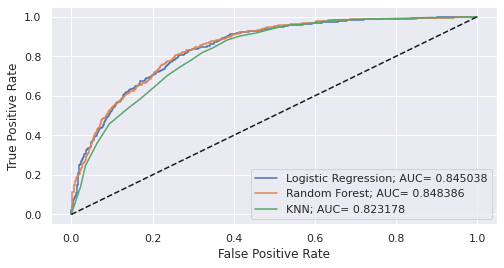

In [46]:
logreg_grid_fpr, logreg_grid_tpr, logreg_grid_thresholds = roc_curve(y_test, y_probs_logreg_grid)
rf_grid_fpr, rf_grid_tpr, rf_grid_thresholds = roc_curve(y_test, y_probs_rf_grid)
knn_grid_fpr, knn_grid_tpr, knn_grid_thresholds = roc_curve(y_test, y_probs_knn_grid)

plt.figure(figsize=(8,4))
plt.plot(logreg_grid_fpr, logreg_grid_tpr, label="Logistic Regression; AUC= %f" % (auc_logreg_grid))
plt.plot(rf_grid_fpr, rf_grid_tpr, label="Random Forest; AUC= %f" % (auc_rf_grid))
plt.plot(knn_grid_fpr, knn_grid_tpr, label="KNN; AUC= %f" % (auc_knn_grid))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.show()

# 10) Understanding Feature Importance


In [47]:
#If looking at Ensemble Model:
importances_best_rf=pd.Series(best_model_rf.feature_importances_, index= X.columns).sort_values(ascending=False)

#If looking at Logistics Regression Model:
#importances_best_logreg=pd.DataFrame({'feature':list(X.columns),'feature_importance':[abs(i) for i in best_model_logreg.coef_[0]]})

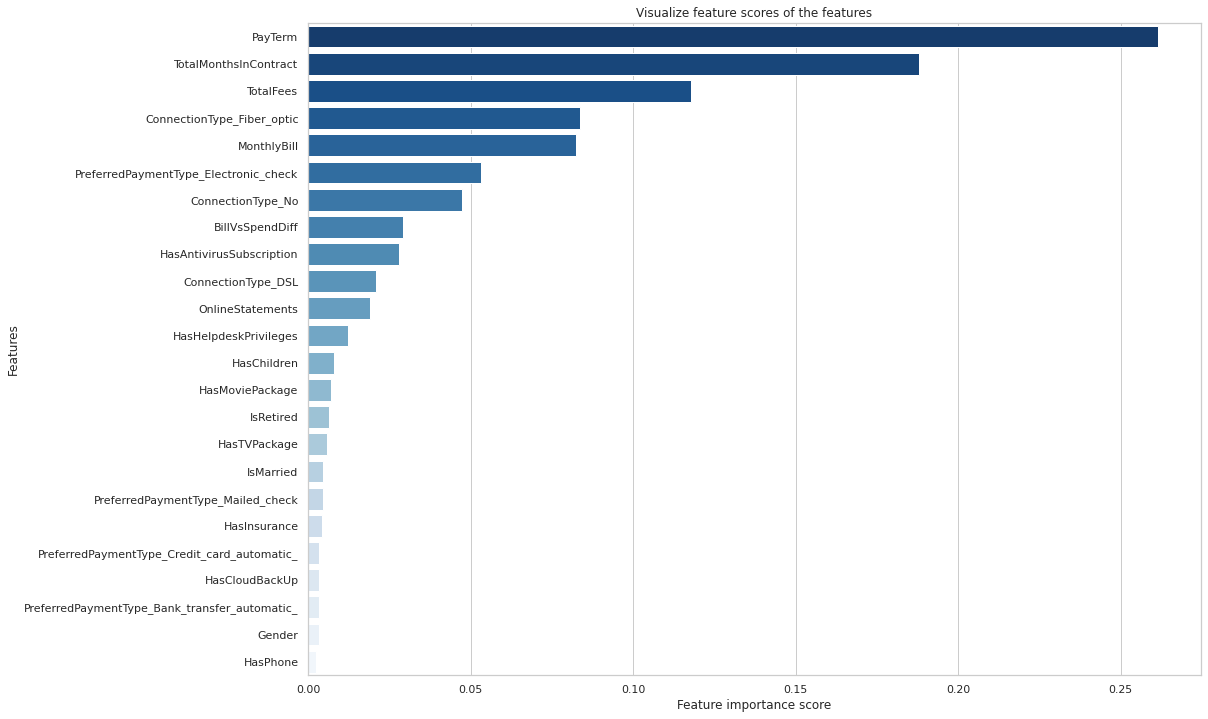

In [51]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(16,12))
ax = sns.barplot(x=importances_best_rf, y=importances_best_rf.index ,palette=("Blues_r"))
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(importances_best_rf.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()